<a href="https://colab.research.google.com/github/takky0330/face/blob/master/OpenPose_face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###インストール

In [1]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
  
from IPython.display import YouTubeVideo

Selecting previously unselected package libgflags2.2.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selecting previously unselected package libleveldb1v5:amd64.
Preparing to unpack ...

### 準備

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
! ls /content/drive/'My Drive'/face_pic | wc -l

4999


### openPose 実行

In [4]:
import glob
import re
import subprocess

In [5]:
def open_pose():
    current_dir       = '/content'
    change_dir       = '/openpose'
    openpose_path = './build/examples/openpose/openpose.bin'
    soruce_path     = '/content/drive/My\ Drive/face_pic/'
    output_path     = '/content/drive/My\ Drive/face_json/'
    res = -1

    #! cd openpose && ./build/examples/openpose/openpose.bin --video ../video.mp4 --write_json ./output/ --display 0  --write_video ../openpose.avi
    os.chdir(current_dir + change_dir)
    print(os.getcwd())
    print('処理画予定像数　：　' + str(len(list(glob.glob(re.sub('\ ', ' ', soruce_path) + '*.*')))))
    command = openpose_path + ' --image_dir ' + soruce_path + ' --write_json ' + output_path + ' --face --hand --display 0 --render_pose 0'
    print(command)
    res = subprocess.call(command, shell=True)
    print('処理済み画像数　：　' + str(len(list(glob.glob(re.sub('\ ', ' ', output_path) + '*.*')))))
    os.chdir(current_dir)
    return res
  

In [6]:
res = open_pose()

/content/openpose
処理画予定像数　：　0
./build/examples/openpose/openpose.bin --image_dir /content/drive/My\ Drive/face_pic/ --write_json /content/drive/My\ Drive/face_json/ --face --hand --display 0 --render_pose 0
処理済み画像数　：　0


0

In [8]:
! df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          69G   33G   33G  50% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
tmpfs           6.4G   16K  6.4G   1% /var/colab
/dev/sda1        75G   34G   42G  45% /opt/bin
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            15G   13G  2.8G  82% /content/drive


### face 情報取得

In [ ]:
def get_face(face_dir):
    face_list = {}
    brn_list = sorted(list(glob.glob(face_dir + '*.*')))
    for _brn in brn_list:
        kp_dict_part = [''] * 5
        with open(_brn, 'r') as json_open:
            keypoint = json.load(json_open)
        brn_name = re.split('\/', _brn).pop(-1)
        img_name = re.split('\.', brn_name).pop(0) + '.jpg'
        try:
            face, eye, nose, mouth = gat_brn([keypoint[people][0]['pose_keypoints_2d']])
        except:
            print('エラー ： ' + img_name)
        kp_dict_part[0] = {'class': 'face', 'x1': int(face[0]), 'x2': int(face[2]), 'y1': int(face[1]), 'y2': int(face[3])}
        kp_dict_part[1] = {'class': 'eye', 'x1': int(eye[0][0]), 'x2': int(eye[0][2]), 'y1': int(eye[0][1]), 'y2': int(eye[0][3])}
        kp_dict_part[2] = {'class': 'eye', 'x1': int(eye[1][0]), 'x2': int(eye[1][2]), 'y1': int(eye[1][1]), 'y2': int(eye[1][3])}
        kp_dict_part[3] = {'class': 'nose', 'x1': int(nose[0]), 'x2': int(nose[2]), 'y1': int(nose[1]), 'y2': int(nose[3])}
        kp_dict_part[4] = {'class': 'mouth', 'x1': int(mouth[0]), 'x2': int(mouth[2]), 'y1': int(mouth[1]), 'y2': int(mouth[3])}
        
        face_list[img_name] = kp_dict_part

    return face_list

In [ ]:
def gat_brn(kp):
    Nose = [kp[0][0*3], kp[0][0*3+1], 0.]
    Neck = (kp[0][1*3], kp[0][1*3+1])

    l_eye = (kp[0][14*3], kp[0][14*3+1])
    r_eye = (kp[0][15*3], kp[0][15*3+1])
    l_ear = (kp[0][16*3], kp[0][16*3+1])
    r_ear = (kp[0][17*3], kp[0][17*3+1])
    if kp[0][16*3+2] == 0.:                        # 左耳が見えない時、左耳は左目の値とする
        l_ear = (l_eye[0], r_ear[1])
        Nose[2] = ((l_ear[0] + r_ear[0]) / 2) - Nose[0]
    if kp[0][17*3+2] == 0.:                        # 右耳が見えない時は、右耳は右目の値とする
        r_ear = (r_eye[0], l_ear[1])
        Nose[2] = ((l_ear[0] + r_ear[0]) / 2 - Nose[0])
    _face_vert = Neck[1] - Nose[1]
    face_vert  = _face_vert * 1.2
    face_vert2 = face_vert / 2.
    face_vert3 = face_vert / 3.
    face_hori  = r_ear[0] - l_ear[0]
    face_hori2 = face_hori / 2. * 1.3
    _w = face_hori / 10.
    _h = face_vert / 10.
    
    eye = [''] * 2
    face   = [(Nose[0] - face_hori2) + Nose[2], Nose[1] - (face_vert2 + face_vert3), (Nose[0] + face_hori2) + Nose[2], Nose[1] + face_vert2]
    eye[0] = [l_eye[0]-(_w*1.5), l_eye[1]-_h, l_eye[0]+(_w*1.5), l_eye[1]+_h]
    eye[1] = [r_eye[0]-(_w*1.5), r_eye[1]-_h, r_eye[0]+(_w*1.5), r_eye[1]+_h]
    nose   = [Nose[0]-(_w*1.5), Nose[1]-(_h*2.5), Nose[0]+(_w*1.5), Nose[1]+(_h*1.)]
    mouth  = [Nose[0] + (Nose[2] / 2.) - (face_hori2 / 2.)
            , Nose[1] + (face_vert3 / 2.) - _h
            , Nose[0] + (Nose[2] / 2.) + (face_hori2 / 2.)
            , Nose[1] + (face_vert3 / 2.) + _h * 1.5]

    return face, eye, nose, mouth

### ファイルアップロード

In [10]:
from google.colab import files
import shutil
uploaded = files.upload()
print(list(uploaded.keys())[0])

#mv_file = list(uploaded.keys())[0]
#new_path = shutil.move(mv_file, '/content/drive/My Drive/')
#print(new_path)

Saving 1回目_rawdata001.csv to 1回目_rawdata001.csv


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



/content/drive/My Drive/1回目_rawdata001.csv


In [18]:
! ls /content/drive/My\ Drive/

 1回目_rawdata001.csv  'Colab Notebooks'   face_pic   sola
 ChatDialog_data        face_json	   KKC	      takky


### 確認等

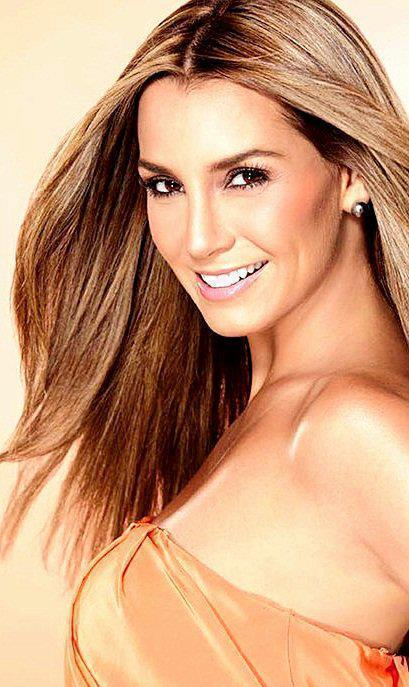

In [ ]:
from IPython.display import Image,display_jpeg
display_jpeg(Image('/content/drive/My Drive/face_pic/000001.jpg'))